In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset
import numpy as np
import random
import matplotlib.pyplot as plt
seed = 2  # fixed seed
np.random.seed(seed)
random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# -------------------
# Setup
# -------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
T = 50          # number of gradient steps per task
hidden_dim = 1000
lr = 0.01

# Number of data points for each task
num_samples_task1 = 100
num_samples_task2 = 50

# -------------------
# Logistic loss
# -------------------
class LogisticLoss(nn.Module):
    def forward(self, preds, labels):
        return torch.mean(torch.log(1 + torch.exp(-labels * preds)))

# -------------------
# Dataset preparation
# -------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=transform
)

def get_binary_task(dataset, class_a, class_b, num_samples):
    idx = np.where((np.array(dataset.targets) == class_a) |
                   (np.array(dataset.targets) == class_b))[0]
    # randomly select num_samples
    idx = np.random.choice(idx, size=num_samples, replace=False)
    subset = Subset(dataset, idx)
    labels = dataset.targets[idx].clone()
    labels[labels == class_a] = 1
    labels[labels == class_b] = -1
    return subset, labels.to(device)

# Task 1: Dress (3) vs Ankle boot (9)
task1_data, task1_labels = get_binary_task(train_dataset, 6, 7, num_samples_task1)
X1_full = torch.stack([task1_data[i][0] for i in range(len(task1_data))]).to(device)
y1_full = task1_labels

# Task 2: T-shirt/top (0) vs Coat (4)
task2_data, task2_labels = get_binary_task(train_dataset, 8,9, num_samples_task2)
X2_full = torch.stack([task2_data[i][0] for i in range(len(task2_data))]).to(device)
y2_full = task2_labels

# -------------------
# Model: 1 hidden layer MLP
# -------------------
class MLP(nn.Module):
    def __init__(self, input_dim=28*28, hidden_dim=256):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.act(self.fc1(x))
        return self.fc2(x).squeeze(-1)

model = MLP(hidden_dim=hidden_dim).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr)
criterion = LogisticLoss()

# -------------------
# Full-batch training loop
# -------------------
per_task_losses = [[], []]
first_task_losses = []

tasks = [(X1_full, y1_full), (X2_full, y2_full)]

for task_id, (X_full, y_full) in enumerate(tasks):
    print(f"Training Task {task_id+1} with full-batch GD ({X_full.size(0)} samples)")
    for t in range(T):
        optimizer.zero_grad()
        logits = model(X_full)
        loss = criterion(logits, y_full)
        loss.backward()
        optimizer.step()

        # Evaluate first task loss
        with torch.no_grad():
            logits_first = model(X1_full)
            loss_first = criterion(logits_first, y1_full)
            first_task_losses.append(loss_first.item())

            loss_current = criterion(logits, y_full)
            per_task_losses[task_id].append(loss_current.item())

        if t % 5 == 0:
            print(f"Iteration {t}: Task {task_id+1} loss = {loss_current.item():.4f}, "
                  f"First task loss = {loss_first.item():.4f}")

print("Final per-task losses:", [losses[-1] for losses in per_task_losses])


Training Task 1 with full-batch GD (100 samples)
Iteration 0: Task 1 loss = 0.7028, First task loss = 0.6461
Iteration 5: Task 1 loss = 0.4975, First task loss = 0.4706
Iteration 10: Task 1 loss = 0.3841, First task loss = 0.3665
Iteration 15: Task 1 loss = 0.3071, First task loss = 0.2946
Iteration 20: Task 1 loss = 0.2515, First task loss = 0.2423
Iteration 25: Task 1 loss = 0.2100, First task loss = 0.2029
Iteration 30: Task 1 loss = 0.1781, First task loss = 0.1727
Iteration 35: Task 1 loss = 0.1532, First task loss = 0.1489
Iteration 40: Task 1 loss = 0.1334, First task loss = 0.1299
Iteration 45: Task 1 loss = 0.1173, First task loss = 0.1145
Training Task 2 with full-batch GD (50 samples)
Iteration 0: Task 2 loss = 0.6583, First task loss = 0.1064
Iteration 5: Task 2 loss = 0.4718, First task loss = 0.1250
Iteration 10: Task 2 loss = 0.3702, First task loss = 0.1358
Iteration 15: Task 2 loss = 0.2991, First task loss = 0.1402
Iteration 20: Task 2 loss = 0.2467, First task loss =


Experiment 1/15

Experiment 2/15

Experiment 3/15

Experiment 4/15

Experiment 5/15

Experiment 6/15

Experiment 7/15

Experiment 8/15

Experiment 9/15

Experiment 10/15

Experiment 11/15

Experiment 12/15

Experiment 13/15

Experiment 14/15

Experiment 15/15


<Figure size 640x480 with 0 Axes>

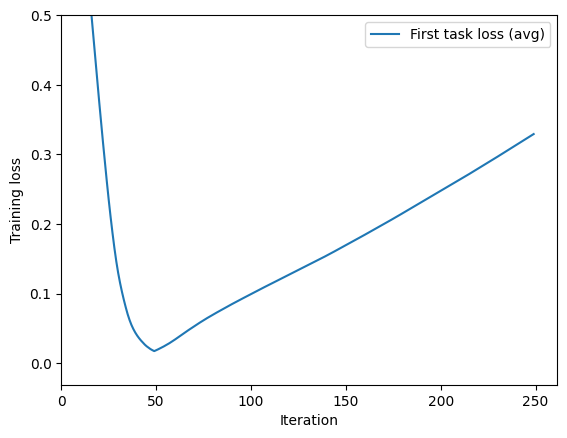

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random
seed = 2  # fixed seed
np.random.seed(seed)
random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
class HingeLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, preds, labels):
        return torch.mean(F.relu(1 - preds * labels))

# -------------------
# Setup
# -------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
T = 50          # number of gradient steps per task
hidden_dim = 500
lr = 0.0003

# Number of data points per task
num_samples_task1 = 50
num_samples_task2 = 200

# Number of experiments
num_experiments = 15

# -------------------
# Logistic loss
# -------------------
class LogisticLoss(nn.Module):
    def forward(self, preds, labels):
        return torch.mean((-labels * preds))

# -------------------
# Dataset preparation
# -------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(
    root="./data",       # folder to store dataset
    train=True,          # True = training set
    download=True,       # download if not already
    transform=transform  # preprocessing
)

def get_binary_task(dataset, class_a, class_b, num_samples):
    idx = np.where((np.array(dataset.targets) == class_a) |
                   (np.array(dataset.targets) == class_b))[0]
    idx = np.random.choice(idx, size=num_samples, replace=False)
    subset = Subset(dataset, idx)
    labels = dataset.targets[idx].clone()
    labels[labels == class_a] = 1
    labels[labels == class_b] = -1
    return subset, labels.to(device)

# -------------------
# Model: 1 hidden layer MLP
# -------------------
class MLP(nn.Module):
    def __init__(self, input_dim=28*28, hidden_dim=256):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_dim, 1, bias=False)

        #self.fc2.weight.data = torch.from_numpy(np.random.choice([-1/hidden_dim**0.5, 1/hidden_dim**0.5], size=(1, hidden_dim))).float() # second layer weights, fixed
        #torch.nn.init.normal_(self.fc1.weight,
                #        mean=0, std=1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.act(self.fc1(x))
        return self.fc2(x).squeeze(-1)

# -------------------
# Run multiple experiments
# -------------------
all_first_task_losses = []
all_per_task_losses = []

for exp in range(num_experiments):
    print(f"\nExperiment {exp+1}/{num_experiments}")

    # Create new model for each experiment
    model = MLP(hidden_dim=hidden_dim).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = HingeLoss()

    # Select task data
    # Task 1: Dress (3) vs Ankle boot (9)
    task1_data, task1_labels = get_binary_task(train_dataset, 0, 1, num_samples_task1)
    X1_full = torch.stack([task1_data[i][0] for i in range(len(task1_data))]).to(device)
    y1_full = task1_labels

    # Task 2: T-shirt/top (0) vs Coat (4)
    task2_data, task2_labels = get_binary_task(train_dataset, 2, 3, num_samples_task2)
    X2_full = torch.stack([task2_data[i][0] for i in range(len(task2_data))]).to(device)
    y2_full = task2_labels

    tasks = [(X1_full, y1_full), (X2_full, y2_full)]

    first_task_losses = []
    per_task_losses = [[], []]

    # Sequential training
    for task_id, (X_full, y_full) in enumerate(tasks):
        for t in range(T):
            optimizer.zero_grad()
            logits = model(X_full)
            loss = criterion(logits, y_full)
            loss.backward()
            optimizer.step()

            # Record losses
            with torch.no_grad():
                logits_first = model(X1_full)
                loss_first = criterion(logits_first, y1_full)
                first_task_losses.append(loss_first.item())

                loss_current = criterion(logits, y_full)
                per_task_losses[task_id].append(loss_current.item())

    all_first_task_losses.append(first_task_losses)
    all_per_task_losses.append(per_task_losses)

# -------------------
# Compute average training loss over experiments
# -------------------
avg_first_task_loss = np.mean(np.array(all_first_task_losses), axis=0)
avg_per_task_losses = [
    np.mean(np.array([per_task_losses[task_id] for per_task_losses in all_per_task_losses]), axis=0)
    for task_id in range(2)
]
fig4 = plt.figure("Figure 1")
fig4, ax = plt.subplots()
# Example: plot first task average loss
plt.plot(avg_first_task_loss, label="First task loss (avg)")
#plt.plot(avg_per_task_losses[0], label="Task 1 loss (avg)")
#plt.plot(avg_per_task_losses[1], label="Task 2 loss (avg)")
plt.xlabel("Iteration")
plt.ylabel("Training loss")
ax.set_xlim(left=0)
ax.set_ylim(top=0.5)
plt.legend()
plt.show()




Experiment 1/15

Experiment 2/15

Experiment 3/15

Experiment 4/15

Experiment 5/15

Experiment 6/15

Experiment 7/15

Experiment 8/15

Experiment 9/15

Experiment 10/15

Experiment 11/15

Experiment 12/15

Experiment 13/15

Experiment 14/15

Experiment 15/15


<Figure size 640x480 with 0 Axes>

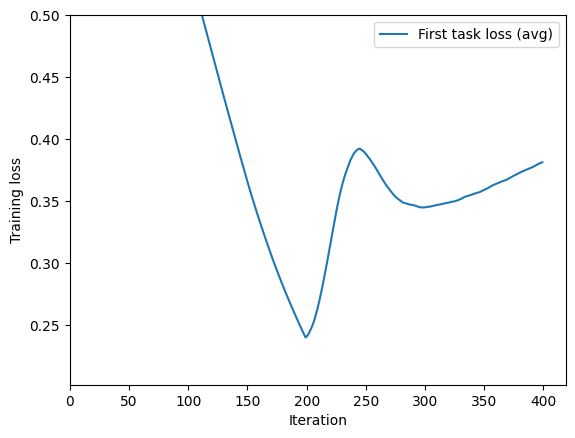

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random
seed = 2  # fixed seed
np.random.seed(seed)
random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
class HingeLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, preds, labels):
        return torch.mean(F.relu(1 - preds * labels))

# -------------------
# Setup
# -------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
T = 200          # number of gradient steps per task
hidden_dim = 500
lr = 0.001

# Number of data points per task
num_samples_task1 = 50
num_samples_task2 = 100

# Number of experiments
num_experiments = 15

# -------------------
# Logistic loss
# -------------------
class LogisticLoss(nn.Module):
    def forward(self, preds, labels):
        return torch.mean((-labels * preds))

# -------------------
# Dataset preparation
# -------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(
    root="./data",       # folder to store dataset
    train=True,          # True = training set
    download=True,       # download if not already
    transform=transform  # preprocessing
)

def get_binary_task(dataset, class_a, class_b, num_samples):
    idx = np.where((np.array(dataset.targets) == class_a) |
                   (np.array(dataset.targets) == class_b))[0]
    idx = np.random.choice(idx, size=num_samples, replace=False)
    subset = Subset(dataset, idx)
    labels = dataset.targets[idx].clone()
    labels[labels == class_a] = 1
    labels[labels == class_b] = -1
    return subset, labels.to(device)

# -------------------
# Model: 1 hidden layer MLP
# -------------------
class MLP(nn.Module):
    def __init__(self, input_dim=28*28, hidden_dim=256):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_dim, 1, bias=False)

        #self.fc2.weight.data = torch.from_numpy(np.random.choice([-1/hidden_dim**0.5, 1/hidden_dim**0.5], size=(1, hidden_dim))).float() # second layer weights, fixed
        #torch.nn.init.normal_(self.fc1.weight,
                #        mean=0, std=1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.act(self.fc1(x))
        return self.fc2(x).squeeze(-1)

# -------------------
# Run multiple experiments
# -------------------
all_first_task_losses = []
all_per_task_losses = []

for exp in range(num_experiments):
    print(f"\nExperiment {exp+1}/{num_experiments}")

    # Create new model for each experiment
    model = MLP(hidden_dim=hidden_dim).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = HingeLoss()

    # Select task data
    # Task 1: Dress (3) vs Ankle boot (9)
    task1_data, task1_labels = get_binary_task(train_dataset, 4, 5, num_samples_task1)
    X1_full = torch.stack([task1_data[i][0] for i in range(len(task1_data))]).to(device)
    y1_full = task1_labels

    # Task 2: T-shirt/top (0) vs Coat (4)
    task2_data, task2_labels = get_binary_task(train_dataset, 6, 7, num_samples_task2)
    X2_full = torch.stack([task2_data[i][0] for i in range(len(task2_data))]).to(device)
    y2_full = task2_labels

    tasks = [(X1_full, y1_full), (X2_full, y2_full)]

    first_task_losses = []
    per_task_losses = [[], []]

    # Sequential training
    for task_id, (X_full, y_full) in enumerate(tasks):
        for t in range(T):
            optimizer.zero_grad()
            logits = model(X_full)
            loss = criterion(logits, y_full)
            loss.backward()
            optimizer.step()

            # Record losses
            with torch.no_grad():
                logits_first = model(X1_full)
                loss_first = criterion(logits_first, y1_full)
                first_task_losses.append(loss_first.item())

                loss_current = criterion(logits, y_full)
                per_task_losses[task_id].append(loss_current.item())

    all_first_task_losses.append(first_task_losses)
    all_per_task_losses.append(per_task_losses)

# -------------------
# Compute average training loss over experiments
# -------------------
avg_first_task_loss = np.mean(np.array(all_first_task_losses), axis=0)
avg_per_task_losses = [
    np.mean(np.array([per_task_losses[task_id] for per_task_losses in all_per_task_losses]), axis=0)
    for task_id in range(2)
]
fig4 = plt.figure("Figure 1")
fig4, ax = plt.subplots()
# Example: plot first task average loss
plt.plot(avg_first_task_loss, label="First task loss (avg)")
#plt.plot(avg_per_task_losses[0], label="Task 1 loss (avg)")
#plt.plot(avg_per_task_losses[1], label="Task 2 loss (avg)")
plt.xlabel("Iteration")
plt.ylabel("Training loss")
ax.set_xlim(left=0)
ax.set_ylim(top=0.5)
plt.legend()
plt.show()



<>:32: SyntaxWarning: invalid escape sequence '\w'
<>:32: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipython-input-3740024507.py:32: SyntaxWarning: invalid escape sequence '\w'
  plt.ylabel('Train-time Forgetting\n $\widehat F_1(w_2)-\widehat F_1(w_1)$')


<Figure size 640x480 with 0 Axes>

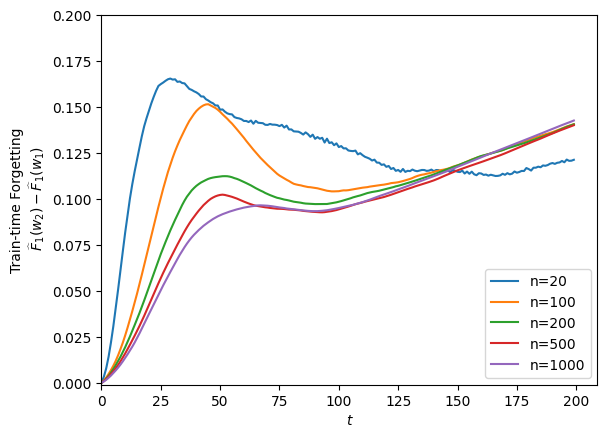

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files

fig4 = plt.figure("Figure 1")
fig4, ax = plt.subplots()
x1 = [x -hold1[200] for x in  hold1[200:]]
x2 = [x -hold2[200] for x in  hold2[200:]]
x3 = [x -hold3[200] for x in  hold3[200:]]
x4 = [x -hold4[200] for x in  hold4[200:]]
x5 = [x -hold5[200] for x in  hold5[200:]]

plt.plot(range(len(hold1)//2),x1,label = 'n=20')
plt.plot(range(len(hold1)//2),x5,label = 'n=100')

plt.plot(range(len(hold1)//2),x2,label = 'n=200')
plt.plot(range(len(hold1)//2),x4,label = 'n=500')

plt.plot(range(len(hold1)//2),x3,label = 'n=1000')

#plt.plot(range(len(hold4)//2),x4,label = 'n=50')

#plt.plot(range(len(hold2)//2),x2,label = 'n=200')
#plt.plot(range(len(hold3)//2),x3,label = 'n=500')


ax.set_xlim(left=0)
ax.set_ylim(top=0.2)
ax.set_ylim(bottom=-.001)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']
plt.xlabel('$t$')
plt.ylabel('Train-time Forgetting\n $\widehat F_1(w_2)-\widehat F_1(w_1)$')
plt.legend()
plt.savefig("loss_curve.eps", bbox_inches="tight",dpi=400)
plt.show(),

files.download("loss_curve.eps")